In [3]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

INPUT_LIB = 'data/'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

def repeat_to_length(arr, length):
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df = pd.read_csv(INPUT_LIB + 'set_a.csv')
df['fname'] = df['fname'].apply(clean_filename, string='Aunlabelledtest')
df = df.dropna(subset=['label'])
df['time_series'] = df['fname'].apply(load_wav_file, path=INPUT_LIB + 'set_a/')    
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN) 
df = df.loc[df['label'] != 'normal']

x_data = np.stack(df['time_series'].values, axis=0)

le = preprocessing.LabelEncoder()
y_data = le.fit_transform(df['label'])
y_data = np_utils.to_categorical(y_data)

x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['fname'].values, test_size=0.25)

x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)

x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [4]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

model = Sequential()
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(3, activation='softmax'))

def batch_generator(x_train, y_train, batch_size):
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
        
        yield x_batch, y_batch
        
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', 
                               save_best_only=True, save_weights_only=True)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [5]:
history = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=1)

Epoch 1/30
1000/1000 [==============================] - 13s 13ms/step - loss: 2.8021 - acc: 0.6699 - val_loss: 1.3820 - val_acc: 0.9167
Epoch 2/30
1000/1000 [==============================] - 11s 11ms/step - loss: 1.0866 - acc: 0.8602 - val_loss: 0.6308 - val_acc: 0.8750
Epoch 3/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5977 - acc: 0.9008 - val_loss: 0.3861 - val_acc: 0.9167
Epoch 4/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.4529 - acc: 0.9100 - val_loss: 0.3154 - val_acc: 0.8750
Epoch 5/30
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3926 - acc: 0.9113 - val_loss: 0.2418 - val_acc: 0.9583
Epoch 6/30
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3518 - acc: 0.9230 - val_loss: 0.2771 - val_acc: 0.9167
Epoch 7/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3031 - acc: 0.9343 - val_loss: 0.1624 - val_acc: 1.0000
Epoch 8/30
1000/1000 [==========================

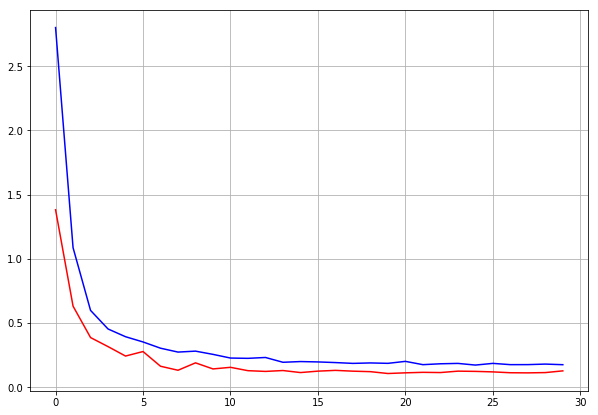

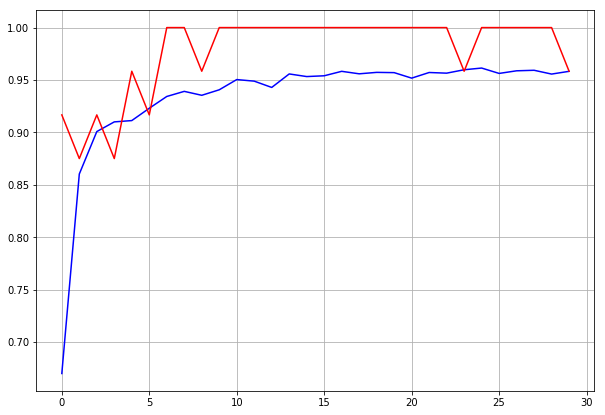

In [6]:
plt.figure(figsize = (10,7))
plt.grid(True)
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()

plt.figure(figsize = (10,7))
plt.grid(True)
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='r')
plt.show()

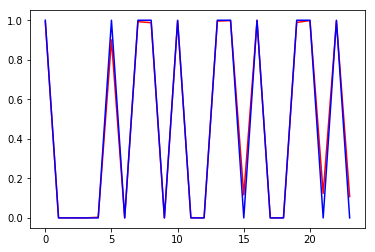

artifact


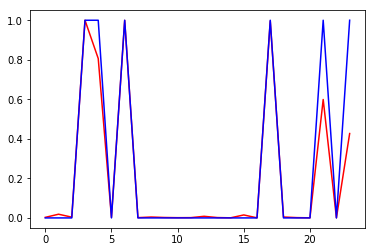

normal


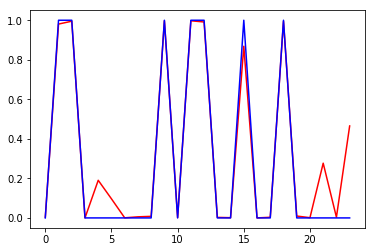

murmur


In [7]:
y_hat = model.predict(x_test)
np.set_printoptions(precision=2, suppress=True)
for i in range(3):
    plt.plot(y_hat[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.show()
    print(CLASSES[i])

In [154]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 1543, 8)           80        
_________________________________________________________________
max_pooling1d_89 (MaxPooling (None, 386, 8)            0         
_________________________________________________________________
batch_normalization_127 (Bat (None, 386, 8)            32        
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 378, 16)           1168      
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 95, 16)            0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 95, 16)            64        
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 87, 32)            4640      
__________